## Real estate price prediction - draft

This draft is a result of a one day hacaton on the subject of prediction of real estate prices (a privat Kaggle competiton on real data).

The rmse success metric was imposed by the competition regulations.

In [18]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt

np.random.seed(0)

import xgboost as xgb
#from sklearn.model_selection import cross_val_score

#from ml_metrics import rmsle
from scikitplot.estimators import plot_learning_curve 
from scikitplot.estimators import plot_feature_importances 
#from eli5.xgboost import explain_weights_xgboost 

#from functools import partial
#from hyperopt import hp
#from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

plt.rcParams['figure.figsize']=(15,5) 

### Load the data

In [2]:
train = pd.read_hdf('./input/train.h5')
test = pd.read_hdf('./input/test.h5')

df = pd.concat([train, test])

df.head()

C:\Users\Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,breadcrumbs,date,date_crawling,geo_block,id,is_test,owner,params,params_en_full,price
4,"[Недвижимость на Move.ru, Москва, МЦК Площадь ...","[17 апреля, 4, (+1 за сегодня), Обновлено 16 мая]",2019-05-21 00:23:07,"[г. Москва, г. Москва]",4,0.0,[],"{'Тип здания:': 'Монолитный', 'Тип объекта:': ...","{'Building type:': 'Monolithic', 'Object type:...",96470000.0
5,"[Недвижимость на Move.ru, Москва, МЦК Коптево]","[14 апреля, 7, (+1 за сегодня), Обновлено 17 мая]",2019-05-20 20:20:58,"[г. Москва, г. Москва]",5,0.0,[ЖК AQUATORIA],"{'Охрана:': 'предусмотрена', 'Тип здания:': 'М...","{'Security:': 'provided', 'Building type:': 'M...",62810000.0
7,"[Недвижимость на Move.ru, Москва, Новая Москва...","[8 февраля, 14, (+1 за сегодня), Обновлено 15 ...",2019-05-21 10:10:30,"[Новая Москва, п. Марушкинское, г. Москва, Нов...",7,0.0,[],"{'Лифт:': 'да', 'Охрана:': 'закрытая территори...","{'Elevator:': 'yes', 'Security:': 'closed area...",6360000.0
8,"[Недвижимость на Move.ru, Москва, Раменки, м. ...","[7 марта, 14, (+1 за сегодня), Обновлено 13 мая]",2019-05-19 23:01:28,"[г. Москва, Раменки, ул Лобачевского, г. Москв...",8,0.0,[],"{'Лифт:': 'да', 'Охрана:': 'закрытая территори...","{'Elevator:': 'yes', 'Security:': 'closed area...",15676538.0
9,"[Недвижимость на Move.ru, Москва, Южное Бутово...","[14 октября 2018, 51, (+1 за сегодня), Обновле...",2019-05-19 14:45:22,"[г. Москва, Южное Бутово, ул Поляны, г. Москва...",9,0.0,[],"{'Лифт:': 'да', 'Охрана:': 'предусмотрена', 'Т...","{'Elevator:': 'yes', 'Security:': 'provided', ...",4078290.0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45566 entries, 4 to 68347
Data columns (total 10 columns):
breadcrumbs       45566 non-null object
date              45566 non-null object
date_crawling     45566 non-null object
geo_block         45566 non-null object
owner             45566 non-null object
params            45566 non-null object
price             45566 non-null int64
params_en_full    45566 non-null object
is_test           45566 non-null int64
id                45566 non-null int64
dtypes: int64(3), object(7)
memory usage: 3.8+ MB


In [4]:
train.isna().sum() # no data is missing

breadcrumbs       0
date              0
date_crawling     0
geo_block         0
owner             0
params            0
price             0
params_en_full    0
is_test           0
id                0
dtype: int64

### Data from params_en_full column

Sample field content:

In [5]:
df['params_en_full'].sample(1).values[0] 

{'Total area:': '35 м²',
 'Date published:': '19 апреля',
 'ID:': '682-130-939-1',
 'Price:': '7 700 000 ₽',
 'Building type:': 'Panel',
 'price per m2:': '220 000 ₽',
 'Number of rooms:': '1',
 'Number of floors:': '16',
 'Updated date:': '15 мая',
 'Object type:': 'apartments',
 'Commission agent:': 'no fee',
 'Ad type:': 'secondary',
 'Address:': '',
 'Floor:': '11/16'}

All unique keyes in params_en_full (for both: train and test data)

In [6]:
all_keys = set()
_ = df['params_en_full'].map(lambda x: all_keys.update(x.keys()) )

all_keys

{'Ad type:',
 'Address:',
 'Balcony type:',
 'Bathroom type:',
 'Building type:',
 'Ceiling height:',
 'Class:',
 'Commission agent:',
 'Construction phase:',
 'Date published:',
 'Developer:',
 'Elevator:',
 'Floor covering:',
 'Floor:',
 'Foundation type:',
 'Free layout:',
 'Fridge:',
 'Furniture:',
 'Garbage chute:',
 'Housing class:',
 'ID:',
 'Internet:',
 'It is possible to bargain:',
 'Kitchen area:',
 'Kitchen furniture:',
 'Living room:',
 'Management company:',
 'Mortgage possible:',
 'New building:',
 'Number of apartments:',
 'Number of buildings:',
 'Number of dwellings:',
 'Number of entrances:',
 'Number of floors:',
 'Number of rooms:',
 'Object type:',
 'Overlap type:',
 'Parking:',
 'Phone:',
 'Playground:',
 'Pre-pay',
 'Price:',
 'Repair:',
 'Room type:',
 'Security:',
 'Series:',
 'Surrender:',
 'TV:',
 'The largest number of floors:',
 'The smallest number of floors:',
 'The view from the window:',
 'Total area:',
 'Type of the building:',
 'Updated date:',
 'Was

Extracting features from params_en_full

In [7]:
df['area'] = df['params_en_full'].map(lambda x: x['Total area:'].split('м')[0].strip() ).astype(np.float)

def extract_floor(x):
    if 'Floor:' not in x: return -1
    return x['Floor:'].split('/')[0]

def extract_living_room(x):
    if 'Living room:' not in x: return -1
    return x['Living room:'].split('м')[0]

def extract_ceiling_height(x):
    if 'Ceiling height:' not in x: return -1
    return x['Ceiling height:'].split('м')[0]

def extract_kitchen_area(x):
    if 'Kitchen area:' not in x: return -1
    return x['Kitchen area:'].split('м')[0]

df['param_floor'] = df['params_en_full'].map(extract_floor ).astype(np.float)
df['param_living room'] = df['params_en_full'].map(extract_living_room).astype(np.float)
df['param_ceiling_height'] = df['params_en_full'].map(extract_ceiling_height ).astype(np.float)
df['param_kitchen_area'] = df['params_en_full'].map(extract_kitchen_area ).astype(np.float)

...More features

In [8]:
# Elevator:

def extract_elevator(x):
    if 'Elevator:' not in x: return -1
    return x['Elevator:'].split()[0]

df['str_elevator'] = df['params_en_full'].map(extract_elevator ).astype(np.str)
df['param_elevator'] = df['str_elevator'].factorize()[0]

# 'Balcony type:',

def extract_balcony(x):
    if 'Balcony type:' not in x: return -1
    return x['Balcony type:'].split()[0]

df['str_balcony'] = df['params_en_full'].map(extract_balcony ).astype(np.str)
df['param_balcony'] = df['str_balcony'].factorize()[0]

# 'Class:',

def extract_class(x):
    if 'Class:' not in x: return -1
    return x['Class:'].split()[0]

df['str_class'] = df['params_en_full'].map(extract_class ).astype(np.str)
df['param_class'] = df['str_class'].factorize()[0]

#'Developer:' : 

def extract_developer(x):
    if 'Developer:' not in x: return -1
    return x['Developer:'].split()[0]

df['str_developer'] = df['params_en_full'].map(extract_developer ).astype(np.str)
df['param_developer'] = df['str_developer'].factorize()[0]  # long tail!!


#'Building type:':
    
def extract_building_type(x):
    if 'Building type:' not in x: return -1
    return x['Building type:'].split()[0]

df['str_building_type'] = df['params_en_full'].map(extract_building_type ).astype(np.str)
df['param_building_type'] = df['str_building_type'].factorize()[0]



# 'New building:',

def extract_new_build(x):
    if 'New building:' not in x: return -1
    return x['New building:'].split()[0]

df['str_new_build'] = df['params_en_full'].map(extract_new_build ).astype(np.str)
df['param_new_build'] = df['str_new_build'].factorize()[0]


# 'Number of rooms:'

def extract_rooms(x):
    if 'Number of rooms:' not in x: return -1
    return x['Number of rooms:'].split()[0]

df['param_rooms'] = df['params_en_full'].map( extract_rooms ).astype(np.int) 

# 'Year built:',

def extract_year(x):
    if 'Year built:' not in x: return -1
    return x['Year built:'].split()[0]

df['param_year'] = df['params_en_full'].map(extract_year ).astype(np.int) # long tail!!


#df['elevator'] = df['params_en_full'].map(lambda x: x['Elevator:'].split()[0].strip() ).astype(np.str)

In [9]:
#df.columns

In [10]:
#df['str_elevator'].values
#df['param_year'].value_counts()

In [11]:
df.sample(5)

,breadcrumbs,date,date_crawling,geo_block,id,is_test,owner,params,params_en_full,price,...,str_class,param_class,str_developer,param_developer,str_building_type,param_building_type,str_new_build,param_new_build,param_rooms,param_year
2431,"[Недвижимость на Move.ru, Москва, Пресненский,...","[15 марта, 11, (+1 за сегодня), Обновлено 13 мая]",2019-05-18 16:38:16,"[г. Москва, Пресненский, г. Москва, Пресненский]",2431,NaN,[],"{'Лифт:': 'да', 'Охрана:': 'предусмотрена', 'Т...","{'Elevator:': 'yes', 'Security:': 'provided', ...",NaN,...,-1,0,Rossmils,38,Monolithic-brick,2,ЖК,0,3,2013
62317,"[Недвижимость на Move.ru, Москва, Дмитровский,...","[2 апреля, 8, (+1 за сегодня), Обновлено 14 мая]",2019-05-19 15:11:13,"[г. Москва, Дмитровский, г. Москва, Дмитровский]",62317,0.0,[],"{'Лифт:': 'да', 'Охрана:': 'предусмотрена', 'Т...","{'Elevator:': 'yes', 'Security:': 'provided', ...",8664150.0,...,-1,0,-1,8,Monolithic,0,Жилой,1,2,-1
61405,"[Недвижимость на Move.ru, Москва, Зябликово, м...","[14 мая, 4, (+1 за сегодня)]",2019-05-18 23:05:41,"[г. Москва, Зябликово, г. Москва, Зябликово]",61405,0.0,[],"{'Лифт:': 'да', 'Охрана:': 'огороженная террит...","{'Elevator:': 'yes', 'Security:': 'fenced area...",13089200.0,...,-1,0,ДОНСТРОЙ,10,Monolithic,0,ЖК,0,3,2022
19422,"[Недвижимость на Move.ru, Москва, Новая Москва...","[14 мая, 6, (+1 за сегодня)]",2019-05-18 23:41:05,"[Новая Москва, п. Сосенское, д. Николо-Хованск...",19422,NaN,[],"{'Лифт:': 'да', 'Охрана:': 'да', 'Тип здания:'...","{'Elevator:': 'yes', 'Security:': 'Yes', 'Buil...",NaN,...,-1,0,ГК,9,Monolithic,0,ЖК,0,2,2020
13113,"[Недвижимость на Move.ru, Москва, Хорошёво-Мнё...","[14 мая, 6, (+1 за сегодня)]",2019-05-18 23:03:34,"[г. Москва, Хорошёво-Мнёвники, г. Москва, Хоро...",13113,0.0,[],"{'Лифт:': 'да', 'Охрана:': 'предусмотрена', 'Т...","{'Elevator:': 'yes', 'Security:': 'provided', ...",28762500.0,...,-1,0,ДОНСТРОЙ,10,Monolithic,0,ЖК,0,4,2020


## Przygotowujemy `X` oraz `y`

In [28]:
features = [ 'area'
            , 'param_floor'
            , 'param_living room'
           # , 'param_ceiling_height'
            , 'param_kitchen_area'
            , 'param_balcony'
            , 'param_elevator'
           # , 'param_class' 
            , 'param_rooms'
            , 'param_year'
            , 'param_new_build'
           # , 'param_developer'
            , 'param_building_type']

In [29]:
train, test = df[ False == df.price.isnull() ], df[ df.price.isnull() ]

X_train = train[ features ].values
y_train = train['price'].values

X_test = test[ features  ].values

### Model

In [42]:
model = xgb.XGBRegressor(max_depth=8, x_subsample= 0.6, n_estimators=300, random_state=0)
y_log = np.log(y_train)
model.fit(X_train, y_log) 

y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)

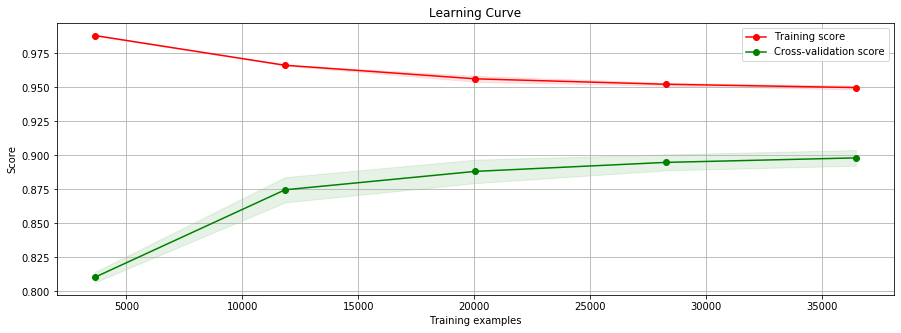

In [43]:
skplt.estimators.plot_learning_curve(model, X_train, y_log, cv=5);


A little bit overfitted, but perform reasonably well on Kaggle.

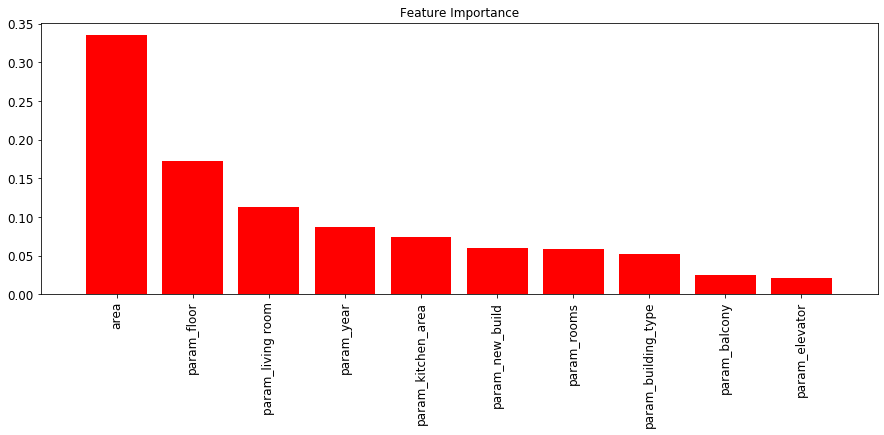

In [44]:
model.fit(X_train, y_train)
skplt.estimators.plot_feature_importances(model, feature_names=features, x_tick_rotation=90, text_fontsize='large' );


### File saving for kaggle

In [47]:
test['price'] = y_pred
test[ ['id', 'price'] ].to_csv('./output/test10.csv', index=False)

C:\Users\Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Next steps

1. Cross validation --> local result validation (due to the lack of time, result (so far) validated on kaggle)
2. Extract more features from the data
3. Remove long tail in features - compartments or logarithmization
4. Eli 5 - feature importance
5. Selecting features (&Overfitting ???)
6. Optional: model optimization